In [1]:
import json, os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
numbering1 = {'340': 'H5.16', '341': 'H5.17', '342': 'H5.18', 
             '343': 'H5.19', '344': 'H5.20', '345': 'H5.21', 
             '346': 'H5.22', '347': 'H5.23', '348': 'H5.24', 
             '349': 'H5.25', '350': 'H5.26'}
res_conv = {'GLN': 'Q', 'VAL': 'V', 'LYS': 'K', 'MET': 'M', 'ARG': 'R',
            'LEU': 'L', 'THR': 'T', 'TYR': 'Y', 'HIS': 'H', 'GLU': 'E',
            'GLY': 'G', 'ILE': 'I', 'ASP': 'D', 'PHE': 'F', 'PRO': 'P',
            'ALA': 'A', 'SER': 'S', 'CYS': 'C', 'ASN': 'N', 'TRP': 'W', 'GLH': 'Q'}
numbering2 = {'340': 0, '341': 1, '342': 2, 
             '343': 3, '344': 4, '345': 5, 
             '346': 6, '347': 7, '348': 8, 
             '349': 9, '350': 10}
def hydrophobic(file, result_dic):
    with open(file, 'r') as fp:
        s = fp.read()
        s = s.replace('\t','')
        s = s.replace('\n','')
        s = s.replace(',}','}')
        s = s.replace(',]',']')
        s = s.replace("'", '"')
        data = json.loads(s)
        for key in data.keys():
            if not key.split('-')[-1] in result_dic.keys():
                position = [0]*11
            else:
                position = result_dic[key.split('-')[-1]]
            if position[numbering2[key[1:4]]]:
                position[numbering2[key[1:4]]].append(float(data[key][:-1])/100)
            else:
                position[numbering2[key[1:4]]]=[float(data[key][:-1])/100]
            result_dic[key.split('-')[-1]] = position
    return result_dic
def hbond(file, result_dic):
    with open(file, 'r') as fp:
        next(fp)
        next(fp)
        for line in fp:
            resid1, resid2, value = line.split()
            if resid1[3:6] in numbering1.keys():
                key = f'{res_conv[resid1[:3]]}{resid1.split("-")[0][3:]}'
                lock = f'{res_conv[resid2[:3]]}{resid2.split("-")[0][3:]}'
            elif resid2[3:6] in numbering1.keys():
                lock = f'{res_conv[resid1[:3]]}{resid1.split("-")[0][3:]}'
                key = f'{res_conv[resid2[:3]]}{resid2.split("-")[0][3:]}'
            if not lock in result_dic.keys():
                position = [None]*11
            else:
                position = result_dic[lock]
            if position[numbering2[key[1:4]]]:
                position[numbering2[key[1:4]]].append(float(value[:-1])/100)
            else:
                position[numbering2[key[1:4]]]=[float(value[:-1])/100]
            result_dic[lock] = position
                
    return result_dic

In [ ]:
peptides = ['MetaII+Gi', 'MetaII+GsGi', 'MetaII+Go', 'MetaII+Gs_ori-Gt', 'MetaII+Gt', 
            'MetaII+Gt-Y', 'MetaII+Gs+CG/G-3PQR-ori', 'MetaII+Gt-E', 'MetaII+Gt-YE']
runs = [10,10,8,5,10,5,10,5,5]
repeats = ['gs_1', 'gs_2', 'gs_3', 'gs2_1', 'gs2_2', 'gs3_1', 'gs3_2', 'gs3_3', 'gs3_4', 'gs3_5']

hbond_path = os.path.join('hbond','hbonds-details-3.5-30-respair.dat')
for index,peptide in enumerate(peptides):
    hbond_dic = {}
    for repeat in repeats:
        basepath = os.path.join(peptide, repeat[:-2], 'analysis', repeat[-1])
        hbondfile = os.path.join(basepath, hbond_path)
        if os.path.isfile(hbondfile):
            hbond_dic = hbond(hbondfile, hbond_dic)
        else:
            print('error',hbondfile)
    df_hbond = pd.DataFrame.from_dict(hbond_dic)
    df_hbond = df_hbond.fillna(np.nan)
    df_hbond = df_hbond.applymap(np.sum)
    df_hbond = df_hbond.div(runs[index])
    df_hbond[df_hbond < 0.05] = np.nan
    df_hbond = df_hbond.dropna(axis=1, how='all')
    df_hbond.to_csv(f'{peptide}_hbond.csv',index=True)


In [ ]:
peptides = ['MetaII+Gi', 'MetaII+GsGi', 'MetaII+Go', 'MetaII+Gs_ori-Gt', 'MetaII+Gt', 
            'MetaII+Gt-Y', 'MetaII+Gs+CG/G-3PQR-ori', 'MetaII+Gt-E', 'MetaII+Gt-YE']
repeats = ['gs_1', 'gs_2', 'gs_3', 'gs2_1', 'gs2_2', 'gs3_1', 'gs3_2', 'gs3_3', 'gs3_4', 'gs3_5']
runs = [10,10,10,5,10,5,10,5,5]
hydrophobic_path = os.path.join('hydrophobic', 'receptorpeptide','percentages.txt')
for index, peptide in enumerate(peptides):
    hydrophobic_dic = {}
    for repeat in repeats:
        basepath = os.path.join(peptide, repeat[:-2], 'analysis', repeat[-1])
        hydrofile = os.path.join(basepath, hydrophobic_path)
        if os.path.isfile(hydrofile):
            hydrophobic_dic = hydrophobic(hydrofile, hydrophobic_dic)
        else:
            print('error',hydrofile)
    df = pd.DataFrame.from_dict(hydrophobic_dic)
    df = df.fillna(np.nan)
    df = df.applymap(np.sum)
    df = df.div(runs[index])
    df[df < 0.05] = np.nan
    df = df.dropna(axis=1, how='all')
    df.to_csv(f'{peptide}_hydrophobic.csv',index=True)


### plotting

In [3]:
H5 = ['H5.16', 'H5.17', 'H5.18', 'H5.19', 'H5.20', 'H5.21', 
                      'H5.22', 'H5.23', 'H5.24', 'H5.25', 'H5.26']
peptides = ['MetaII+Gi', 'MetaII+GsGi', 'MetaII+Go', 'MetaII+Gs_ori-Gt', 'MetaII+Gt', 
            'MetaII+Gt-Y', 'MetaII+Gs+CG/G-3PQR-ori', 'MetaII+Gt-E', 'MetaII+Gt-YE']
peptide_clean = ['Gi', 'GsGi', 'Go', 'Gs*', 'Gt', 
            'Gt-Y', 'Gs-CG*', 'Gt-E', 'Gt-YE']
repeats = ['gs_1', 'gs_2', 'gs_3', 'gs2_1', 'gs2_2', 'gs3_1', 'gs3_2', 'gs3_3', 'gs3_4', 'gs3_5']
runs = [10,10,10,5,10,5,10,5,5]
hydrophobic_path = os.path.join('hydrophobic', 'receptorpeptide','percentages.txt')
all_df = [['res1', 'res2', 'H5', 'receptor', 'value', 'peptide']]
for index, peptide in enumerate(peptides):
    hydrophobic_dic = {}
    for repeat in repeats:
        basepath = os.path.join(peptide, repeat[:-2], 'analysis', repeat[-1])
        hydrofile = os.path.join(basepath, hydrophobic_path)
        if os.path.isfile(hydrofile):
            hydrophobic_dic = hydrophobic(hydrofile, hydrophobic_dic)
        else:
            print('error',hydrofile)
    df = pd.DataFrame.from_dict(hydrophobic_dic)
    df = df.fillna(0)
    df = df.applymap(np.sum)
    df = df.div(runs[index])
   # df[df < 0.05] = np.nan
    df = df.dropna(axis=1, how='all')
    for contact in df:
        for ind, elem in enumerate(df[contact]):
            if elem >= 0.05:
                all_df.append([ind, int(contact[1:]),H5[ind],contact,elem,peptide_clean[index]])
all_df = pd.DataFrame(all_df[1:], columns=all_df[0])
all_df = all_df.sort_values(by=['res2'], ascending=[False])
unique_contacts = all_df.receptor.unique()
print(unique_contacts)
all_df['res22'] = all_df['receptor']
for index, cont in enumerate(unique_contacts):
    all_df.loc[all_df.receptor == cont, 'res22'] = index
#all_df = all_df.sort_values(by=['res2', 'res1'], ascending=[False, True])
all_df

error MetaII+Gs_ori-Gt/gs3/analysis/1/hydrophobic/receptorpeptide/percentages.txt
error MetaII+Gs_ori-Gt/gs3/analysis/2/hydrophobic/receptorpeptide/percentages.txt
error MetaII+Gs_ori-Gt/gs3/analysis/3/hydrophobic/receptorpeptide/percentages.txt
error MetaII+Gs_ori-Gt/gs3/analysis/4/hydrophobic/receptorpeptide/percentages.txt
error MetaII+Gs_ori-Gt/gs3/analysis/5/hydrophobic/receptorpeptide/percentages.txt
error MetaII+Gt-Y/gs3/analysis/1/hydrophobic/receptorpeptide/percentages.txt
error MetaII+Gt-Y/gs3/analysis/2/hydrophobic/receptorpeptide/percentages.txt
error MetaII+Gt-Y/gs3/analysis/3/hydrophobic/receptorpeptide/percentages.txt
error MetaII+Gt-Y/gs3/analysis/4/hydrophobic/receptorpeptide/percentages.txt
error MetaII+Gt-Y/gs3/analysis/5/hydrophobic/receptorpeptide/percentages.txt
error MetaII+Gt-E/gs3/analysis/1/hydrophobic/receptorpeptide/percentages.txt
error MetaII+Gt-E/gs3/analysis/2/hydrophobic/receptorpeptide/percentages.txt
error MetaII+Gt-E/gs3/analysis/3/hydrophobic/recept

,res1,res2,H5,receptor,value,peptide,res22
219,8,313,H5.24,F313,0.05194,Gt-Y,0
218,7,313,H5.23,F313,0.08794,Gt-Y,0
228,8,312,H5.24,Q312,0.14231,Gs-CG*,1
320,8,312,H5.24,Q312,0.10294,Gt-YE,1
60,5,312,H5.21,Q312,0.11918,GsGi,1
...,...,...,...,...,...,...,...
306,6,72,H5.22,L72,0.06804,Gt-YE,29
198,6,72,H5.22,L72,0.23982,Gt-Y,29
17,7,72,H5.23,L72,0.10030,Gi,29
16,6,72,H5.22,L72,0.48193,Gi,29


In [4]:
H5 = ['H5.16', 'H5.17', 'H5.18', 'H5.19', 'H5.20', 'H5.21', 
                      'H5.22', 'H5.23', 'H5.24', 'H5.25', 'H5.26']
peptides = ['MetaII+Gi', 'MetaII+GsGi', 'MetaII+Go', 'MetaII+Gs_ori-Gt', 'MetaII+Gt', 
            'MetaII+Gt-Y', 'MetaII+Gs+CG/G-3PQR-ori', 'MetaII+Gt-E', 'MetaII+Gt-YE']
peptide_clean = ['Gi', 'GsGi', 'Go', 'Gs*', 'Gt', 
            'Gt-Y', 'Gs-CG*', 'Gt-E', 'Gt-YE']
repeats = ['gs_1', 'gs_2', 'gs_3', 'gs2_1', 'gs2_2', 'gs3_1', 'gs3_2', 'gs3_3', 'gs3_4', 'gs3_5']
runs = [10,10,10,5,10,5,10,5,5]
all_df_hbond = [['res1', 'res2','res22', 'H5', 'receptor', 'value', 'peptide']]


hbond_path = os.path.join('hbond','hbonds-details-3.5-30-respair.dat')

for index, peptide in enumerate(peptides):
    hbond_dic = {}
    for repeat in repeats:
        basepath = os.path.join(peptide, repeat[:-2], 'analysis', repeat[-1])
        hbondfile = os.path.join(basepath, hbond_path)
        if os.path.isfile(hbondfile):
            hbond_dic = hbond(hbondfile, hbond_dic)
        else:
            print('error',hbondfile)
    df_hbond = pd.DataFrame.from_dict(hbond_dic)
    df_hbond = df_hbond.fillna(0)
    df_hbond = df_hbond.applymap(np.sum)
    df_hbond = df_hbond.div(runs[index])
    #df_hbond[df_hbond < 0.05] = np.nan
    df_hbond = df_hbond.dropna(axis=1, how='all')
    for indi, contact in enumerate(df_hbond):
        for ind, elem in enumerate(df_hbond[contact]):
            if elem >= 0.05:
                all_df_hbond.append([ind, int(contact[1:]), indi ,H5[ind],contact,elem,peptide_clean[index]])
all_df_hbond = pd.DataFrame(all_df_hbond[1:], columns=all_df_hbond[0])
#all_df = all_df.sort_values(by=['res2', 'res1'], ascending=[False, True])

all_df_hbond = all_df_hbond.sort_values(by=['res2'], ascending=[False])
unique_contacts_hbond = all_df_hbond.receptor.unique()
print(unique_contacts_hbond)
all_df_hbond['res22'] = all_df_hbond['receptor']
for index, cont in enumerate(unique_contacts_hbond):
    all_df_hbond.loc[all_df_hbond.receptor == cont, 'res22'] = index
#all_df = all_df.sort_values(by=['res2', 'res1'], ascending=[False, True])
all_df_hbond

error MetaII+Go/gs3/analysis/4/hbond/hbonds-details-3.5-30-respair.dat
error MetaII+Go/gs3/analysis/5/hbond/hbonds-details-3.5-30-respair.dat
error MetaII+Gs_ori-Gt/gs3/analysis/1/hbond/hbonds-details-3.5-30-respair.dat
error MetaII+Gs_ori-Gt/gs3/analysis/2/hbond/hbonds-details-3.5-30-respair.dat
error MetaII+Gs_ori-Gt/gs3/analysis/3/hbond/hbonds-details-3.5-30-respair.dat
error MetaII+Gs_ori-Gt/gs3/analysis/4/hbond/hbonds-details-3.5-30-respair.dat
error MetaII+Gs_ori-Gt/gs3/analysis/5/hbond/hbonds-details-3.5-30-respair.dat
error MetaII+Gt-Y/gs3/analysis/1/hbond/hbonds-details-3.5-30-respair.dat
error MetaII+Gt-Y/gs3/analysis/2/hbond/hbonds-details-3.5-30-respair.dat
error MetaII+Gt-Y/gs3/analysis/3/hbond/hbonds-details-3.5-30-respair.dat
error MetaII+Gt-Y/gs3/analysis/4/hbond/hbonds-details-3.5-30-respair.dat
error MetaII+Gt-Y/gs3/analysis/5/hbond/hbonds-details-3.5-30-respair.dat
error MetaII+Gt-E/gs3/analysis/1/hbond/hbonds-details-3.5-30-respair.dat
error MetaII+Gt-E/gs3/analysis

,res1,res2,res22,H5,receptor,value,peptide
75,0,342,0,H5.16,E342,0.05790,Gt-Y
76,4,340,1,H5.20,I340,0.10690,Gt-Y
46,8,314,2,H5.24,R314,0.20820,Gs*
65,5,312,3,H5.21,Q312,0.06312,Gt-Y
51,5,312,3,H5.21,Q312,0.06297,Gt
...,...,...,...,...,...,...,...
45,8,70,22,H5.24,T70,0.05324,Gs*
102,8,70,22,H5.24,T70,0.06104,Gt-E
74,6,67,23,H5.22,K67,0.06230,Gt-Y
19,6,67,23,H5.22,K67,0.08842,GsGi


In [ ]:
day = all_df.sort_values(by=['res2'], ascending=[ True])

#day = day.sort_values(by=['res1'], ascending=[True])
plt.figure(figsize=(8.5,7))


sns.stripplot(x='res1', y='receptor', hue='peptide', data=day, jitter=True,dodge=True)
             #   s=day['value']*50,  alpha=.25)#, style='value', palette=['green','orange','brown','blue']
#sns.scatterplot(x='res1', y='receptor', hue='peptide', data=day, x_jitter=200,
#                legend='full', s=day['value']*200)#, style='value', palette=['green','orange','brown','blue']
#


plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("2020_10_23_out1.png")

In [ ]:
day = all_df.sort_values(by=['res2'], ascending=[ True])

#day = day.sort_values(by=['res1'], ascending=[True])
plt.figure(figsize=(8.5,7))


sns.stripplot(x='res1', y='receptor', hue='peptide', data=day, jitter=True,)
              #  s=day['value']*50, alpha=.5,)
#sns.scatterplot(x='res1', y='receptor', hue='peptide', data=day, x_jitter=200,
#                legend='full', s=day['value']*200)#, style='value', palette=['green','orange','brown','blue']
#


plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("2020_10_23_out2.png")

In [ ]:
plt.close()
plt.figure(figsize=(10,15))

day = all_df.sort_values(by=['res2'], ascending=[ True])
#sns.set_theme(style="ticks")

sns.catplot(x="res1", y="receptor", hue="peptide", kind="swarm", data=day, orient='v')

plt.savefig("2020_10_23_out3.png")


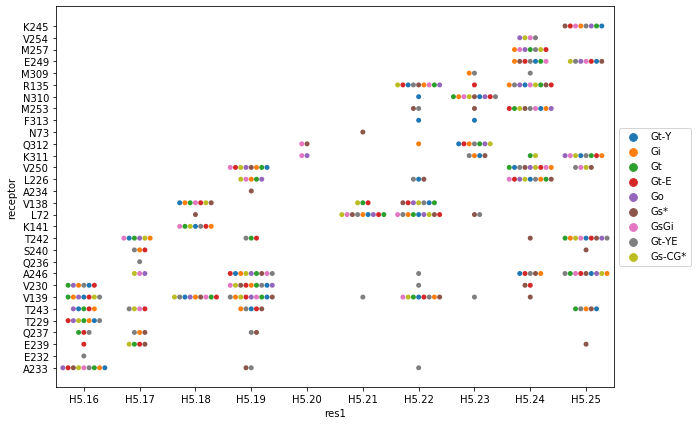

In [5]:
day = all_df.sort_values(by=['res2'], ascending=[ False])

plt.figure(figsize=(10,7))
#sns.scatterplot(x='H5', y='receptor', hue='peptide', data=day, legend='full', s=day['value']*200)#, style='value', palette=['green','orange','brown','blue']
ax = sns.swarmplot( x="res1", y="receptor", data=day, hue='peptide', orient='v')#, s=day['value']*100)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xticklabels( ('H5.16', 'H5.17', 'H5.18', 'H5.19', 'H5.20', 'H5.21', 
                      'H5.22', 'H5.23', 'H5.24', 'H5.25', 'H5.26') )
plt.savefig("2020_10_23_out4.png")


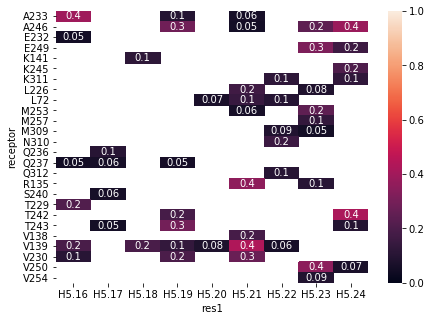

In [95]:
plt.figure(figsize=(7,5))
i=8
ax.set_title(peptide_clean[i],fontweight="bold", size=10) # Title
day1 = all_df.sort_values(by=['res2'], ascending=[ True])
day = day1.loc[day1['peptide'] == peptide_clean[i]]
flights = day.pivot("receptor", "res1", "value")
ax = sns.heatmap(flights,
               cbar=True,
               vmin=0, vmax=1,annot=True, fmt='0.1g')
ax.set_xticklabels( ('H5.16', 'H5.17', 'H5.18', 'H5.19', 'H5.20', 'H5.21', 
                      'H5.22', 'H5.23', 'H5.24', 'H5.25', 'H5.26') )
plt.savefig(f"2020_10_23_out5_{peptide_clean[i]}.png")


/Users/kxp752/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 1440x1440 with 0 Axes>

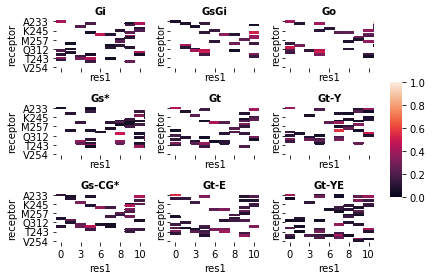

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.figure(figsize=(20,20))
#sns.set_context('talk', font_scale=1) 
fig, axn = plt.subplots(3, 3, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
day1 = all_df.sort_values(by=['res2'], ascending=[ True])

for i, ax in enumerate(axn.flat):
    ax.set_title(peptide_clean[i],fontweight="bold", size=10) # Title
    day = day1.loc[day1['peptide'] == peptide_clean[i]]
    flights = day.pivot("receptor", "res1", "value")
    sns.heatmap(flights, ax=ax,
                   cbar=i == 0,
                   vmin=0, vmax=1,
                   cbar_ax=None if i else cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig("2020_10_23_out5.png")


In [ ]:
day = all_df.sort_values(by=['res2', 'res1'], ascending=[False, True])
sns.set(rc={'figure.figsize':(10,20)}) 
sns.set_context('talk', font_scale=2) 
sns.set_style('ticks')
sns.color_palette("rocket_r")
g = sns.relplot(x='res1', y='res22', hue='value', data=day, palette='rocket_r',#['green','orange','brown','blue'],
                col='peptide', col_wrap=3, legend=False, s=day['value']*5000,
                height=13,aspect=1.2,  sizes=(100,800))# 

g.fig.suptitle('Contact frequency' ,position=(0.5,1.05), fontweight='bold', size=30)
g.set_xlabels("G-protein peptide residue",fontweight='bold', size=30)
g.set_ylabels("Receptor residue",fontweight='bold', size=30);
plt.savefig("2020_10_23_out6.png")


### hbond


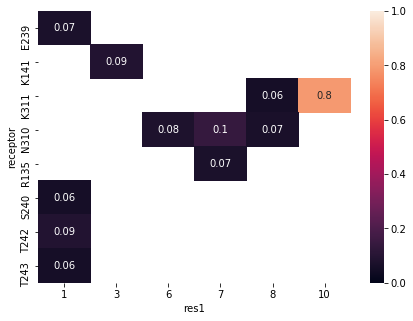

In [106]:
plt.figure(figsize=(7,5))
i=0
ax.set_title(peptide_clean[i],fontweight="bold", size=10) # Title
day1 = all_df_hbond.sort_values(by=['res2'], ascending=[ True])
day = day1.loc[day1['peptide'] == peptide_clean[i]]
flights = day.pivot("receptor", "res1", "value")
sns.heatmap(flights,
               cbar=True,
               vmin=0, vmax=1,annot=True, fmt='0.1g')
ax.set_xticklabels( ('H5.16', 'H5.17', 'H5.18', 'H5.19', 'H5.20', 'H5.21', 
                      'H5.22', 'H5.23', 'H5.24', 'H5.25', 'H5.26') )
plt.savefig(f"2020_10_23_hbond_out5_{peptide_clean[i]}.png")


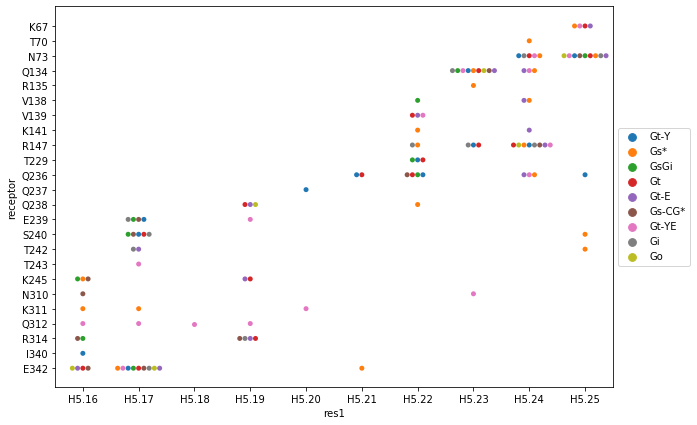

In [6]:
day = all_df_hbond.sort_values(by=['res2'], ascending=[ False])

plt.figure(figsize=(10,7))
#sns.scatterplot(x='H5', y='receptor', hue='peptide', data=day, legend='full', s=day['value']*200)#, style='value', palette=['green','orange','brown','blue']
ax = sns.swarmplot( x="res1", y="receptor", data=day, hue='peptide', orient='v')#, s=day['value']*100)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xticklabels( ('H5.16', 'H5.17', 'H5.18', 'H5.19', 'H5.20', 'H5.21', 
                      'H5.22', 'H5.23', 'H5.24', 'H5.25', 'H5.26') )
ax.set_yticklabels( unique_contacts_hbond )
plt.savefig("2020_10_23_hbond_out4.png")


In [ ]:
day = all_df_hbond.sort_values(by=['res2', 'res1'], ascending=[False, True])
sns.set(rc={'figure.figsize':(10,20)}) 
sns.set_context('talk', font_scale=2) 
sns.set_style('ticks')
sns.color_palette("rocket_r")
g = sns.relplot(x='res1', y='res22', hue='peptide', data=day, palette='rocket_r',#['green','orange','brown','blue'],
                col='peptide', col_wrap=3, legend=False, s=day['value']*5000,
                height=13,aspect=1.2,  sizes=(100,800))# 

g.fig.suptitle('Contact frequency' ,position=(0.5,1.05), fontweight='bold', size=30)
g.set_xlabels("G-protein peptide residue",fontweight='bold', size=30)
g.set_ylabels("Receptor residue",fontweight='bold', size=30);
g.set_xticklabels( ('H5.16', 'H5.17', 'H5.18', 'H5.19', 'H5.20', 'H5.21', 
                      'H5.22', 'H5.23', 'H5.24', 'H5.25', 'H5.26') )
g.set_yticklabels( unique_contacts_hbond )
plt.savefig("2020_10_23_hbond_out6.png")
